In [1]:
!git clone https://github.com/Mike030668/Project_glass.git -q

In [2]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  import os
  os.chdir('/content/Project_glass')
  os.getcwd()

else:
  print('Not running on CoLab')

Running on CoLab


In [18]:
from prepare_data.const_predprice import  TARGET_COLS, BASE_COLS, BATCH_SIZE, DEPTH, PREDICT_LAG
from prepare_data.constants import GLASS_COLS
import numpy as np # библиотека нампи
import matplotlib.pyplot as plt # библиотека матплотлиб для отрисовки
from IPython.display import clear_output # очистка вывода в ячейке

import tensorflow as tf           # библиотека машинного обучения

In [7]:
x_train_sc = np.load("./predprice/x_train_sc.npy")
x_val_sc = np.load("./predprice/x_val_sc.npy")
y_train_sc = np.load("./predprice/y_train_sc.npy")
y_val_sc = np.load("./predprice/y_val_sc.npy")

In [8]:
# Для генерации выборки временных рядов
TSG = tf.keras.preprocessing.sequence.TimeseriesGenerator

# Создаем генератор для обучения
train_datagen = TSG(x_train_sc, y_train_sc,          # В качестве параметров наши выборки
                    length = DEPTH,            # Анализируем по 21 прошедшим точкам
                    sampling_rate = 1,         # Для каждой точки
                    batch_size = BATCH_SIZE)   # Размер batch, который будем скармливать модели

# Создаем аналогичный генератор для валидации при обучении
val_datagen = TSG(x_val_sc, y_val_sc,                # В качестве параметров наши выборки
                    length = DEPTH,            # Анализируем по 21 прошедшим точкам
                    sampling_rate = 1,         # Для каждой точки
                    batch_size = BATCH_SIZE)   # Размер batch, который будем скармливать модели

print(train_datagen[0][0].shape,
      val_datagen[0][1].shape)

# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки/оценки
DataGen = TSG(x_val_sc, y_val_sc,              # В качестве параметров наши выборки
              length = DEPTH,            # Анализируем по 21 прошедшим точкам
              sampling_rate = 1,         # Для каждой точки
              batch_size = len(x_val_sc))   # Размер batch будет равен длине нашей выборки


# сформируем сами массивы для проверки
XVAL, YVAL = [], []
for i in DataGen:
  XVAL.append(i[0])
  YVAL.append(i[1])

# так как это список объектов
# мы вытаскиваем нужный нам
XVAL = np.array(XVAL)[0]
YVAL = np.array(YVAL)[0]
print(XVAL.shape,YVAL.shape)

(64, 32, 53) (64, 5)
(530, 32, 53) (530, 5)


In [20]:
from construct_model.make_models import baseline, model_prepprice_path_colab

model= baseline(input_shape = XVAL.shape[1:],
                    pred_num = PREDICT_LAG,
                    activ_out = "linear",
                    depth= DEPTH)


In [21]:
# понижение шага
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 mode='min',
                                                 factor = 0.8,
                                                 patience = 3,
                                                 min_lr = 1e-9,
                                                 verbose = 1)

# остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

path_model = model_prepprice_path_colab

# Сохранение модели
checkpoint  = tf.keras.callbacks.ModelCheckpoint(
                        filepath = path_model,
                        #save_weights_only=True,
                        monitor='val_loss',
                        mode='min',
                        save_best_only=True
                        )
# оптимизатор
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

# функция потерь
loss = tf.keras.losses.Huber() #.MSE #
model.compile(optimizer = optimizer, loss = loss, metrics=['mae', 'mape'])

In [22]:
# обучение модели вашей
history = model.fit(train_datagen,                  # генератор данных для обучения
                    validation_data = val_datagen, # генератор данных для проверки
                    epochs = 150,
                    callbacks=[early_stopping, reduce_lr, checkpoint],
                    verbose = 1)

Epoch 1/150
34/34 [==============================] - 17s 352ms/step - loss: 0.0783 - mae: 0.3166 - mape: 218834.3281 - val_loss: 0.0099 - val_mae: 0.1185 - val_mape: 24.7792 - lr: 0.0010
Epoch 2/150
34/34 [==============================] - 10s 316ms/step - loss: 0.0373 - mae: 0.2171 - mape: 99867.3750 - val_loss: 0.0083 - val_mae: 0.1074 - val_mape: 23.4708 - lr: 0.0010
Epoch 3/150
34/34 [==============================] - 11s 328ms/step - loss: 0.0205 - mae: 0.1609 - mape: 63478.3086 - val_loss: 0.0048 - val_mae: 0.0804 - val_mape: 16.5321 - lr: 0.0010
Epoch 4/150
34/34 [==============================] - 11s 326ms/step - loss: 0.0121 - mae: 0.1236 - mape: 54065.5391 - val_loss: 0.0032 - val_mae: 0.0655 - val_mape: 13.8765 - lr: 0.0010
Epoch 5/150
34/34 [==============================] - 11s 326ms/step - loss: 0.0099 - mae: 0.1121 - mape: 83646.8828 - val_loss: 0.0029 - val_mae: 0.0619 - val_mape: 12.4611 - lr: 0.0010
Epoch 6/150
34/34 [==============================] - 9s 277ms/step - 

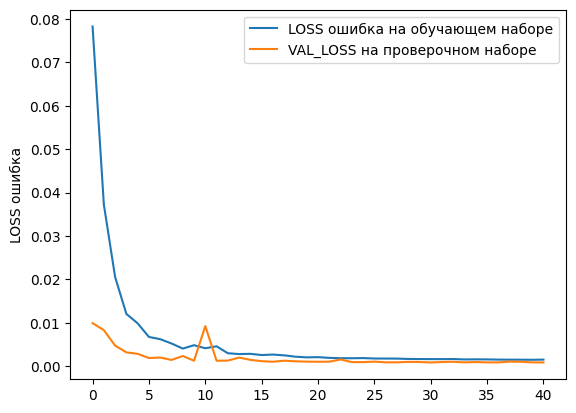

In [23]:
plt.plot(history.history['loss'],
         label='LOSS ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='VAL_LOSS на проверочном наборе')
plt.ylabel('LOSS ошибка')
plt.legend()
plt.show()